<a href="https://colab.research.google.com/github/yumpy/fastai-course-v3/blob/master/notes/dl1/pets-resnet50.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pets - Resnet50

In [0]:
!pip install -q torch==1.0.0 torchvision 

In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
from fastai.vision import *
from fastai.metrics import error_rate

In [0]:
bs = 64
# bs = 16   # uncomment this line if you run out of memory even after clicking Kernel->Restart

## Getting the data

We are going to use the [Oxford-IIIT Pet Dataset](http://www.robots.ox.ac.uk/~vgg/data/pets/) by [O. M. Parkhi et al., 2012](http://www.robots.ox.ac.uk/~vgg/publications/2012/parkhi12a/parkhi12a.pdf) which features 12 cat breeds and 25 dogs breeds. Our model will need to learn to differentiate between these 37 distinct categories. According to their paper, the best accuracy they could get in 2012 was 59.21%, using a complex model that was specific to pet detection, with separate "Image", "Head", and "Body" models for the pet photos. Let's see how accurate we can be using deep learning!

We are going to use the `untar_data` function to which we must pass a URL as an argument and which will download and extract the data.

In [0]:
path = untar_data(URLs.PETS); path

PosixPath('/home/sgugger/.fastai/data/oxford-iiit-pet')

In [0]:
path.ls()

[PosixPath('/home/sgugger/.fastai/data/oxford-iiit-pet/images'),
 PosixPath('/home/sgugger/.fastai/data/oxford-iiit-pet/annotations')]

In [0]:
path_anno = path/'annotations'
path_img = path/'images'

The first thing we do when we approach a problem is to take a look at the data. We _always_ need to understand very well what the problem is and what the data looks like before we can figure out how to solve it. Taking a look at the data means understanding how the data directories are structured, what the labels are and what some sample images look like.

The main difference between the handling of image classification datasets is the way labels are stored. In this particular dataset, labels are stored in the filenames themselves. We will need to extract them to be able to classify the images into the correct categories. Fortunately, the fastai library has a handy function made exactly for this, `ImageDataBunch.from_name_re` gets the labels from the filenames using a [regular expression](https://docs.python.org/3.6/library/re.html).

In [0]:
fnames = get_image_files(path_img)
fnames[:5]

[PosixPath('/home/ubuntu/.fastai/data/oxford-iiit-pet/images/saint_bernard_188.jpg'),
 PosixPath('/home/ubuntu/.fastai/data/oxford-iiit-pet/images/staffordshire_bull_terrier_114.jpg'),
 PosixPath('/home/ubuntu/.fastai/data/oxford-iiit-pet/images/Persian_144.jpg'),
 PosixPath('/home/ubuntu/.fastai/data/oxford-iiit-pet/images/Maine_Coon_268.jpg'),
 PosixPath('/home/ubuntu/.fastai/data/oxford-iiit-pet/images/newfoundland_95.jpg')]

In [0]:
np.random.seed(2)
pat = r'/([^/]+)_\d+.jpg$'

## Training: resnet50

Now we will train in the same way as before but with one caveat: instead of using resnet34 as our backbone we will use resnet50 (resnet34 is a 34 layer residual network while resnet50 has 50 layers. It will be explained later in the course and you can learn the details in the [resnet paper](https://arxiv.org/pdf/1512.03385.pdf)).

Basically, resnet50 usually performs better because it is a deeper network with more parameters. Let's see if we can achieve a higher performance here. To help it along, let's us use larger images too, since that way the network can see more detail. We reduce the batch size a bit since otherwise this larger network will require more GPU memory.

In [0]:
data = ImageDataBunch.from_name_re(path_img, fnames, pat, ds_tfms=get_transforms(),
                                   size=299, bs=bs//2).normalize(imagenet_stats)

In [0]:
learn = cnn_learner(data, models.resnet50, metrics=error_rate)

LR Finder complete, type {learner_name}.recorder.plot() to see the graph.


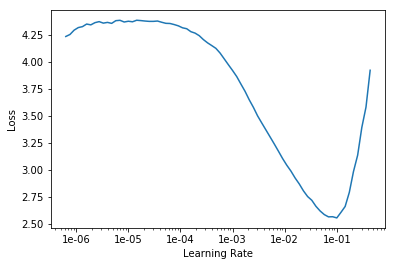

In [0]:
learn.lr_find()
learn.recorder.plot()

In [0]:
learn.fit_one_cycle(8)

Total time: 06:59
epoch  train_loss  valid_loss  error_rate
1      0.548006    0.268912    0.076455    (00:57)
2      0.365533    0.193667    0.064953    (00:51)
3      0.336032    0.211020    0.073072    (00:51)
4      0.263173    0.212025    0.060893    (00:51)
5      0.217016    0.183195    0.063599    (00:51)
6      0.161002    0.167274    0.048038    (00:51)
7      0.086668    0.143490    0.044655    (00:51)
8      0.082288    0.154927    0.046008    (00:51)



In [0]:
learn.save('stage-1-50')

It's astonishing that it's possible to recognize pet breeds so accurately! Let's see if full fine-tuning helps:

In [0]:
learn.unfreeze()
learn.fit_one_cycle(3, max_lr=slice(1e-6,1e-4))

Total time: 03:27
epoch  train_loss  valid_loss  error_rate
1      0.097319    0.155017    0.048038    (01:10)
2      0.074885    0.144853    0.044655    (01:08)
3      0.063509    0.144917    0.043978    (01:08)



If it doesn't, you can always go back to your previous model.

In [0]:
learn.load('stage-1-50');

In [0]:
interp = ClassificationInterpretation.from_learner(learn)

In [0]:
interp.most_confused(min_val=2)

[('american_pit_bull_terrier', 'staffordshire_bull_terrier', 6),
 ('Bengal', 'Egyptian_Mau', 5),
 ('Bengal', 'Abyssinian', 4),
 ('boxer', 'american_bulldog', 4),
 ('Ragdoll', 'Birman', 4),
 ('Egyptian_Mau', 'Bengal', 3)]